## Tracking Error Minimization
---

### Passive Management Vs. Active Management

+ So far we have reviewed how to manage our portfolio in terms of the balance between the expected return and the risk (the variance or the expected shortfall). This style of portfolio management is called <font color=red>active management</font>. Active management also involves discretionary selection of assets.

+ <font color=red>Passive management</font> of a portfolio, on the other hand, is a investment strategy in which an investor tries to mimic a benchmark index. Passive management funds that mimic indices are called \alert{index funds}. As the benchmark portfolio, index funds use stock indices, bond indices, currencies, commodities, or even hedge funds.

+ The goal in passive management is to minimize a discrepancy between a portfolio and the benchmark index. 


In [1]:
import numpy as np
import scipy.stats as st
import cvxpy as cvx
import pandas as pd
import matplotlib.pyplot as plt

Here we generate artificial stock return data and save them in the CSV file `asset_return_data.csv`.

In [2]:
Mu = np.array([1.0, 3.0, 1.5, 6.0, 4.5])
Stdev = np.array([5.0, 10.0, 7.5, 15.0, 11.0])
CorrMatrix = np.array([[1.00, 0.25, 0.18, 0.10, 0.25],
                       [0.25, 1.00, 0.36, 0.20, 0.20],
                       [0.18, 0.36, 1.00, 0.25, 0.36],
                       [0.10, 0.20, 0.25, 1.00, 0.45],
                       [0.25, 0.20, 0.36, 0.45, 1.00]])
Sigma = np.diag(Stdev) @  CorrMatrix @ np.diag(Stdev)
np.random.seed(9999)
T = 120
End_of_Month = pd.date_range('1/1/2010', periods=T, freq='M')
Asset_Names = ['Asset 1', 'Aseet 2', 'Asset3', 'Asset 4', 'Asset 5']
Asset_Return = pd.DataFrame(st.multivariate_normal.rvs(mean=Mu, cov=Sigma, size=T),
                            index=End_of_Month, columns=Asset_Names)
Asset_Return.to_csv('asset_return_data.csv')

Then we read the generate data from `asset_return_data.csv` again.

In [3]:
R = pd.read_csv('asset_return_data.csv', index_col=0)
R = R.asfreq(pd.infer_freq(R.index))
T, N = R.shape
np.random.seed(8888)
BenchmarkIndex = R.dot(np.tile(1.0/N, N)) + st.norm.rvs(loc=0.0, scale=3.0, size=T)

### Tracking Error

Let $y_t$ denote the return on the benchmark index at time $t$, $r_{nt}$ denote the return on asset $n$ $(n=1,\dots,N)$ at time $t$ $(t=1,\dots,T)$, and $w_n$ denote the allocation weight for asset $n$. Then a discrepancy between a portfolio and the benchmark index at time $t$ is given by
\begin{equation}
\begin{split}
 e_t &= y_t - \sum_{n=1}^N w_n r_{nt}
 = y_t - \begin{bmatrix} r_{1t} & \cdots & r_{Nt}\end{bmatrix}
 \begin{bmatrix} w_1\\ \vdots \\ w_N \end{bmatrix} \\
 &= y_t - r_t^{\intercal}w.
\end{split}
\end{equation}
This discrepancy is called a <font color=red>tracking error</font>. 


Define

\begin{equation*}
 y = \begin{bmatrix} y_1 \\ \vdots \\ y_T \end{bmatrix},\quad
 R = \begin{bmatrix} r_1^{\intercal} \\ \vdots \\ r_T^{\intercal} \end{bmatrix},\quad
 e = \begin{bmatrix} e_1 \\ \vdots \\ e_T \end{bmatrix}.
\end{equation*}

The tracking error minimization problem is defined as 

\begin{equation*}
\begin{split}
 \min_{w} & \quad \frac1{T}e^{\intercal}e, \\
 \text{subject to} & \quad  e = y-Rw,\quad w^{\intercal}\iota = 1,\quad w\geqq 0.
\end{split}
\end{equation*}


In [4]:
MovingWindow = 96
BackTesting = T - MovingWindow
V_Tracking = np.zeros(BackTesting)
Weight = cvx.Variable(N)
Error = cvx.Variable(MovingWindow)
TrackingError = cvx.sum_squares(Error)
Asset_srT = R / np.sqrt(T)
Index_srT = BenchmarkIndex / np.sqrt(T)
for Month in range(0, BackTesting):
    Asset = Asset_srT.values[Month:(Month + MovingWindow), :]
    Index = Index_srT.values[Month:(Month + MovingWindow)]
    Min_TrackingError = cvx.Problem(cvx.Minimize(TrackingError),
                                    [Index - Asset*Weight == Error,
                                     cvx.sum(Weight) == 1.0,
                                     Weight >= 0.0])
    Min_TrackingError.solve(solver=cvx.ECOS)
    V_Tracking[Month] = R.values[Month + MovingWindow, :].dot(Weight.value)

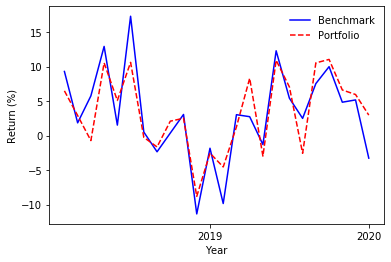

In [5]:
fig1 = plt.figure(num=1, facecolor='w')
plt.plot(list(range(1, BackTesting + 1)), BenchmarkIndex[MovingWindow:], 'b-', label='Benchmark')
plt.plot(list(range(1, BackTesting + 1)), V_Tracking, 'r--', label='Portfolio')
plt.legend(loc='best', frameon=False)
plt.xlabel('Year')
plt.ylabel('Return (%)')
plt.xticks(list(range(12, BackTesting + 1, 12)),
           pd.date_range(R.index[MovingWindow], periods=BackTesting//12, freq='AS').year)
plt.show()